# Response to Step inputs

we feed the neuron with spikes drawn from an inhomogeneous Poisson process whose time-varying rate is set by step functions

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

import sys
from parallel import Parallel

sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../analyz')
from analyz.processing.signanalysis import autocorrel, crosscorrel

# Run

### Basket Cell
```
    python step_stim.py --test_with_repeats -c Basket\
                        --with_presynaptic_spikes\
                        --stimFreq 10e-3\
                        --bgFreqInhFactor 1\
                        --iBranch 1 --nSpikeSeed 102
```
### Martinotti Cell
```
    python step_stim.py --test_with_repeats -c Martinotti\
                        --with_NMDA\
                        --with_presynaptic_spikes\
                        --stimFreq 4e-4\
                        --bgFreqInhFactor 1\
                        --iBranch 1 --nSpikeSeed 102
```

# Plot

           exc syn. rate: 0.6 +/- 0.0 Hz
              --> average release proba (of single events): 0.30 
           exc syn. rate: 3.4 +/- 0.1 Hz
              --> average release proba (of single events): 0.90 


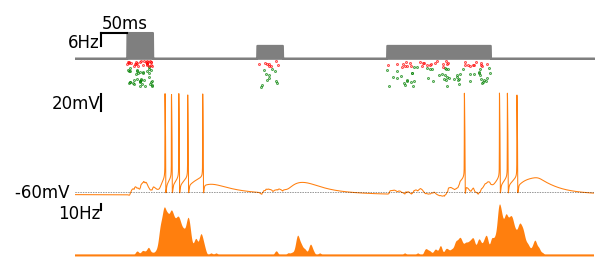

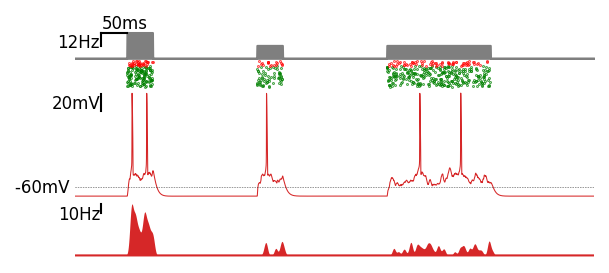

In [37]:
rate_smoothing = 3. # ms
zoom = [100,1100]

RESULTS = {'Martinotti_example_index':1, # *50* 33, 42, 49, 50
           'Basket_example_index':2} # 31

def load_sim(cellType, RESULTS):
    
    sim = Parallel(\
            filename='../data/detailed_model/StepStim_demo_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.spikeSeed)
    
    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
    RESULTS['%s_rate' % cellType] = []
    for i, spikes in enumerate(sim.spikes):
        spikes_matrix[i,(spikes/dt).astype('int')] = True
    RESULTS['rate_%s' % cellType] = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                           int(rate_smoothing/dt))
    RESULTS['stimFreq_%s' % cellType] = sim.fetch_quantity_on_grid('stimFreq', return_last=True)
    RESULTS['bgFreqInhFactor_%s' % cellType] = sim.fetch_quantity_on_grid('bgFreqInhFactor', return_last=True)
    RESULTS['t'] = np.arange(len(RESULTS['rate_%s' % cellType]))*dt
    RESULTS['dt'] = dt    

    sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
    sim.fetch_quantity_on_grid('Stim', return_last=True, dtype=np.ndarray)
    mean_input_rate = np.mean(sim.Stim[0])*RESULTS['stimFreq_%s' % cellType]
    syn_exc_rates = [np.mean([1e3*len(E)/tstop for E in sim.presynaptic_exc_events[i]]) for i in range(len(seeds))]
    print('           exc syn. rate: %.1f +/- %.1f Hz' % (np.mean(syn_exc_rates), np.std(syn_exc_rates)))
    print('              --> average release proba (of single events): %.2f ' % (np.mean(syn_exc_rates)/mean_input_rate))


def load_example_index(cellType, RESULTS):
    
    sim = Parallel(\
            filename='../data/detailed_model/StepStim_demo_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('Stim', return_last=True, dtype=np.ndarray)
    RESULTS['Input_%s' % cellType] = sim.Stim[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('Vm_soma', return_last=True, dtype=np.ndarray)
    RESULTS['Vm_%s' % cellType] = sim.Vm_soma[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
    RESULTS['pre_exc_%s' % cellType] = sim.presynaptic_exc_events[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('presynaptic_inh_events', dtype=list)
    RESULTS['pre_inh_%s' % cellType] = sim.presynaptic_inh_events[RESULTS['%s_example_index' % cellType]]
        

def plot_sim(cellType, color='k', example_index=None, figsize=(1.2,0.6)):

    fig, AX = pt.figure(axes_extents=[[(1,1)],[(1,1)],[(1,4)],[(1,2)]],
                        figsize=figsize, left=0, bottom=0., hspace=0.)

    # input
    AX[0].fill_between(RESULTS['t'][:-1][::20], 0*RESULTS['t'][:-1][::20], RESULTS['Input_%s' % cellType][::20],
                       color='tab:grey', lw=1)

    # Vm
    AX[2].plot(RESULTS['t'][::10], RESULTS['Vm_%s' % cellType][::10], color=color, lw=0.5)
    AX[2].plot(RESULTS['t'][::100], -60+0*RESULTS['t'][::100], 'k:', lw=0.3)

    # rate
    if RESULTS['rate_%s' % cellType] is not None:
        AX[3].fill_between(RESULTS['t'][::20], 0*RESULTS['t'][::20], RESULTS['rate_%s' % cellType][::20],
                           color=color, lw=0)
        AX[3].plot(RESULTS['t'][::20], 0*RESULTS['t'][::20], color=color, lw=1)
        
    # events
    if 'pre_inh_%s' % cellType in RESULTS:
        subsampling = 4 if 'Basket' in cellType else 1
        # 1/4 for display
        for i, events in enumerate(RESULTS['pre_exc_%s' % cellType]):
            if len(events)>0:
                e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                AX[1].plot(e, i*np.ones(len(e)), 'o', fillstyle='full', color='g', ms=.3)
        for i, events in enumerate(RESULTS['pre_inh_%s' % cellType]):
            if len(events)>0:
                e = np.random.choice(events, np.min([int(len(events)/subsampling+1),1]), replace=False)
                AX[1].plot(e, len(RESULTS['pre_exc_%s' % cellType])+i*np.ones(len(e)), 'o', 
                           fillstyle='full', color='r', ms=.3)

    pt.set_common_xlims(AX, lims=zoom)
    
    pt.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=1,
                       Ybar_label='%.0fHz' % (RESULTS['stimFreq_%s' % cellType]))
    pt.annotate(AX[2], '-60mV ', (zoom[0],-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[2], Xbar=1e-12, Ybar=20,Ybar_label='20mV')
    #pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    #pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[3], Xbar=1e-12, Ybar=10,Ybar_label='10Hz')
    return fig, AX
    #fig.savefig('../figures/Figure5/StepSim_example_%s.svg' % cellType)

#for cellType in ['Martinotti', 'Basket', 'MartinottinoNMDA', 'BasketUniform']:
for cellType, color, index in zip(['Martinotti', 'Basket'],
                                  ['tab:orange', 'tab:red', 'tab:orange', 'tab:red'],
                                  [31,16,31,16]):
    
    load_sim(cellType, RESULTS) 
    RESULTS['%s_example_index' % cellType] = index # change here !
    load_example_index(cellType, RESULTS) 
        
    fig, _ = plot_sim(cellType, color=color, figsize=(2.,0.3))
    fig.savefig('../figures/Temp-Properties-Pred/StepSim_example_%s.svg' % cellType)

## Look for traces

In [ ]:
for cellType, color in zip(['Martinotti'], ['tab:orange']):
    
    load_sim(cellType, RESULTS) 
    for example_index in range(0, 32):
        RESULTS['%s_example_index' % cellType] = example_index
        load_example_index(cellType, RESULTS) 
        fig, _ = plot_sim(cellType, color=color)

# Summary Effect

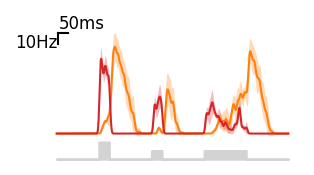

In [44]:
rate_smoothing = 5. # ms

zoom = [150, 1100]

RESULTS = {'Martinotti_example_index':1, # *50* 33, 42, 49, 50
           'Basket_example_index':2} # 31

def load_sim(cellType, suffix):

    rates = []
    for iBranch in range(6):
        sim = Parallel(\
                filename='../data/detailed_model/StepStim_sim_iBranch%i_%s_%s.zip' % (iBranch, cellType, suffix))
        sim.load()
        sim.fetch_quantity_on_grid('spikes', dtype=list)
        seeds = np.unique(sim.spikeSeed)
        dt = sim.fetch_quantity_on_grid('dt', return_last=True)
        tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)
        spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
        for i, spikes in enumerate(sim.spikes):
            spikes_matrix[i,(spikes/dt).astype('int')] = True
        rates.append(1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                   int(rate_smoothing/dt)))
        input = sim.fetch_quantity_on_grid('Stim', return_last=True, dtype=np.ndarray)

    return np.arange(len(rates[0]))*dt, input, rates    


def plot_sim(cellTypes, suffixs, colors, lines=['-','-','-','-'], Ybar=10):

    fig, AX = pt.figure(axes_extents=[[(1,6)],[(1,1)]],
                        figsize=(1.4,0.2), left=0, bottom=0., hspace=0.)
    for ax in AX:
        ax.axis('off')
    for cellType, suffix, color, line in zip(cellTypes, suffixs, colors, lines):
        t, input, rates = load_sim(cellType, suffix)
        pt.plot(t, np.mean(rates, axis=0), sy=np.std(rates, axis=0), ax=AX[0], color=color, lw=0)
        AX[0].plot(t, np.mean(rates, axis=0), color=color, linestyle=line)
    AX[1].fill_between(t[1:], 0*t[1:], input, color='lightgrey')
    pt.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=Ybar, Ybar_label='%.0fHz' % Ybar)
    pt.set_common_xlims(AX)
    return fig, AX

fig, _ = plot_sim(['Martinotti', 'Basket'], ['','withSTP'], ['tab:orange', 'tab:red'])
fig.savefig('../figures/Temp-Properties-Pred/PV-vs-SST.svg')

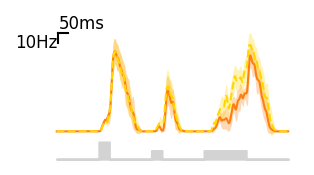

In [45]:
plot_sim(['Martinotti', 'Martinotti', 'Martinotti'], ['','withSTP'],
         ['tab:orange', 'gold', 'tab:purple'], lines=['-','--'])
fig.savefig('../figures/Temp-Properties-Pred/SST-models.svg')

(<Figure size 215.433x135.827 with 1 Axes>, <Axes: >)

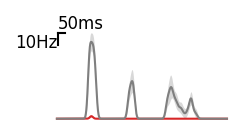

In [15]:
plot_sim(['Basket', 'Basket'], ['','withSTP'], ['tab:red', 'tab:grey'])